In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.feature_selection import f_classif
import lightgbm as lgb


In [2]:
df = pd.read_csv('df_final.csv')
#df.drop(df.iloc[:,0], axis = 1, inplace= True)

In [84]:
df.shape



(743151, 40)

In [4]:
#df.drop_duplicates(inplace= True)

In [5]:
df.shape

(743154, 38)

In [6]:
len(df.columns)

38

In [7]:
def grab_col_names(df, cat_th=5):
    # cat_cols, cat_but_car
    cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
    num_but_cat = [col for col in df.columns if df[col].nunique() < cat_th and
                   df[col].dtypes != "O"]
    #cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in df.columns if df[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {df.shape[0]}")
    print(f"Variables: {df.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, num_but_cat

In [8]:
cat_cols, num_cols, num_but_cat =  grab_col_names(df)

Observations: 743154
Variables: 38
cat_cols: 14
num_cols: 19
num_but_cat: 5


In [9]:
num_cols

['SK_ID_CURR',
 'AMT_CREDIT_x',
 'AMT_INCOME_TOTAL',
 'CREDIT_INCOME_RATIO',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'CNT_FAM_MEMBERS',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE.1',
 'DEF_60_CNT_SOCIAL_CIRCLE.1',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_ANNUITY_x',
 'AMT_GOODS_PRICE_x']

In [10]:
num_but_cat

['TARGET',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT_W_CITY',
 'Total_Documents',
 'REGION_RATING_CLIENT']

# Function for treating Outlier

In [11]:
def outlier_th(df, col_name, q1=0.05, q3=0.95):
    quartile1 = df[col_name].quantile(q1)
    quartile3 = df[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# Define a Function about checking outlier for data columns
def check_outlier(df, col_name):
    low_limit, up_limit = outlier_th(df, col_name)
    if df[(df[col_name] > up_limit) | (df[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

# Define a Function about replace with threshold for data columns
def replace_with_thresholds(df, variable):
    low_limit, up_limit = outlier_th(df, variable)
    df.loc[(df[variable] < low_limit), variable] = low_limit
    df.loc[(df[variable] > up_limit), variable] = up_limit

In [86]:
def skewplot(df, column):
    plt.figure(figsize=(20, 4))

    # Distplot
    plt.subplot(1, 3, 1)
    sns.histplot(df[column], kde=True)
    plt.title("Distplot for " + column)


    # Boxplot
    plt.subplot(1, 3, 2)
    sns.boxplot(df[column])
    plt.title("Box plot for " + column)

    # Violin plot
    plt.subplot(1, 3, 3)
    sns.violinplot(df[column])
    plt.title("Violin plot for " + column)

    plt.tight_layout()
    plt.show()

/var/folders/7d/hppk4q955wx8kcl4r2ll10dm0000gn/T/ipykernel_89194/1201161540.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)


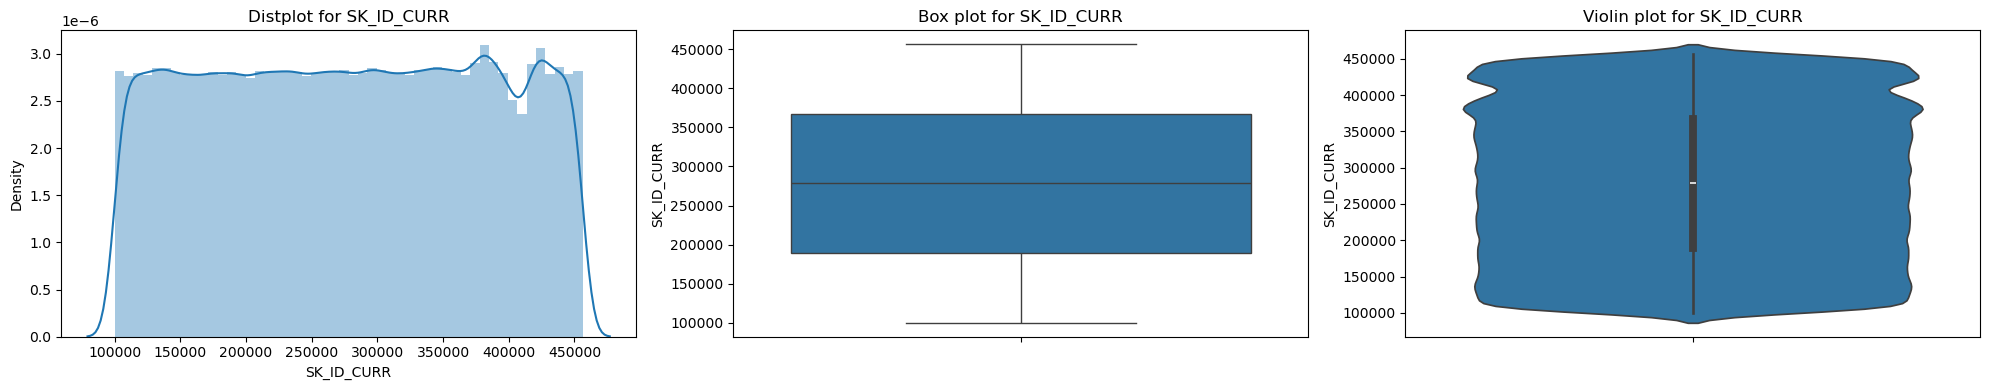

/var/folders/7d/hppk4q955wx8kcl4r2ll10dm0000gn/T/ipykernel_89194/1201161540.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)


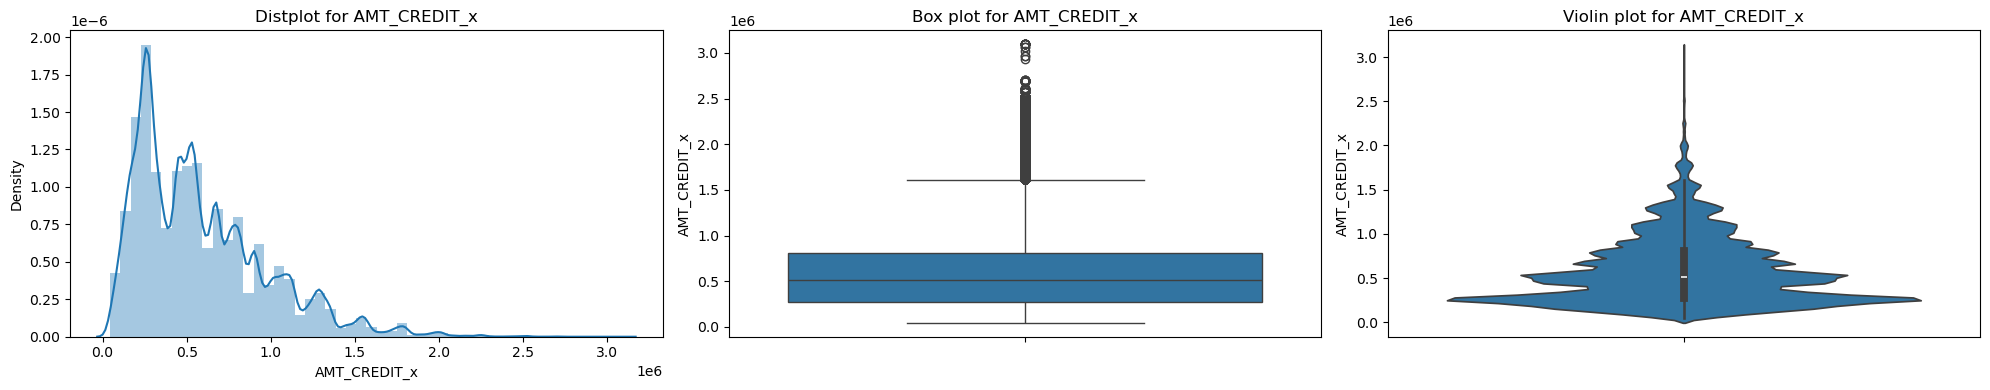

/var/folders/7d/hppk4q955wx8kcl4r2ll10dm0000gn/T/ipykernel_89194/1201161540.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)


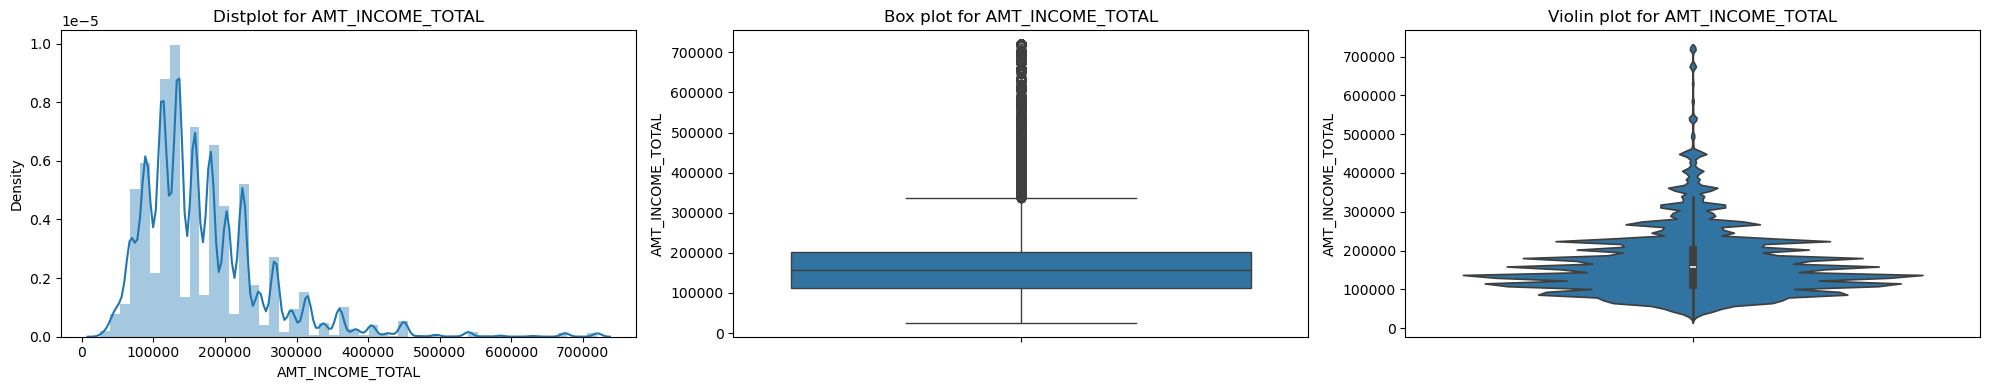

/var/folders/7d/hppk4q955wx8kcl4r2ll10dm0000gn/T/ipykernel_89194/1201161540.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)


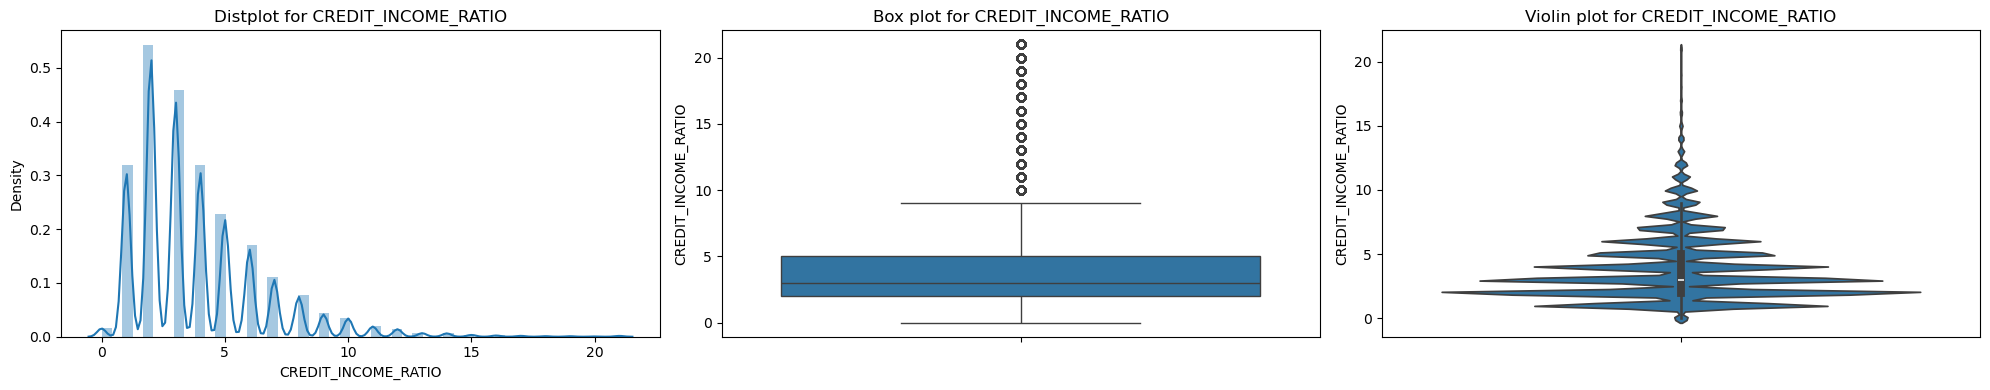

/var/folders/7d/hppk4q955wx8kcl4r2ll10dm0000gn/T/ipykernel_89194/1201161540.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)


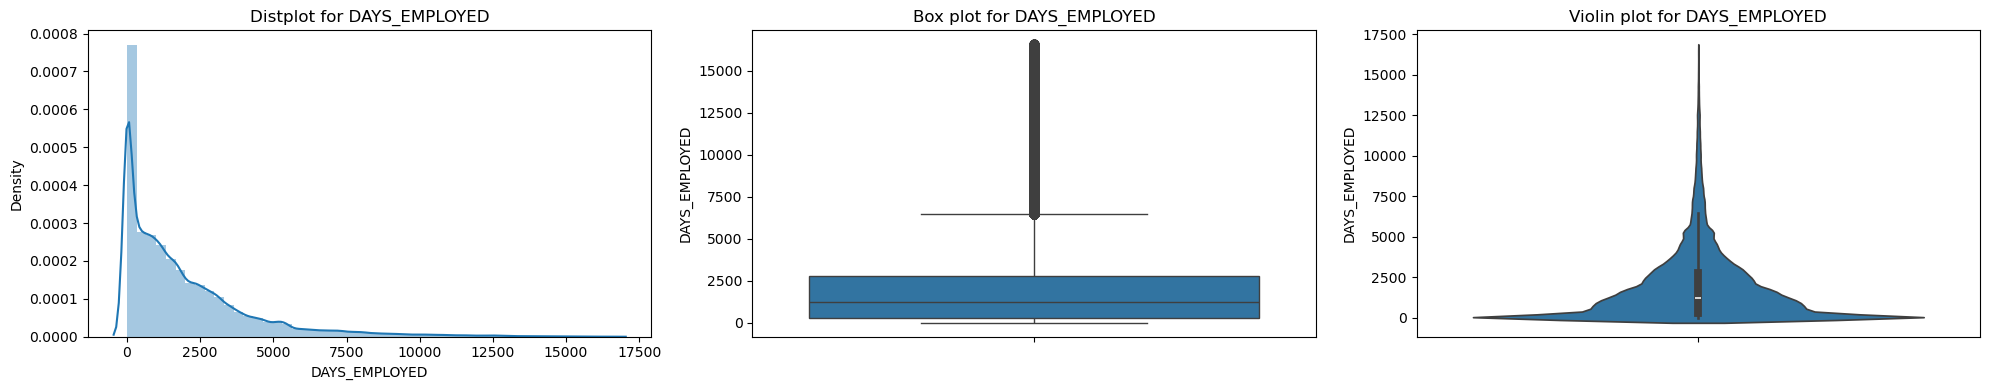

/var/folders/7d/hppk4q955wx8kcl4r2ll10dm0000gn/T/ipykernel_89194/1201161540.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)


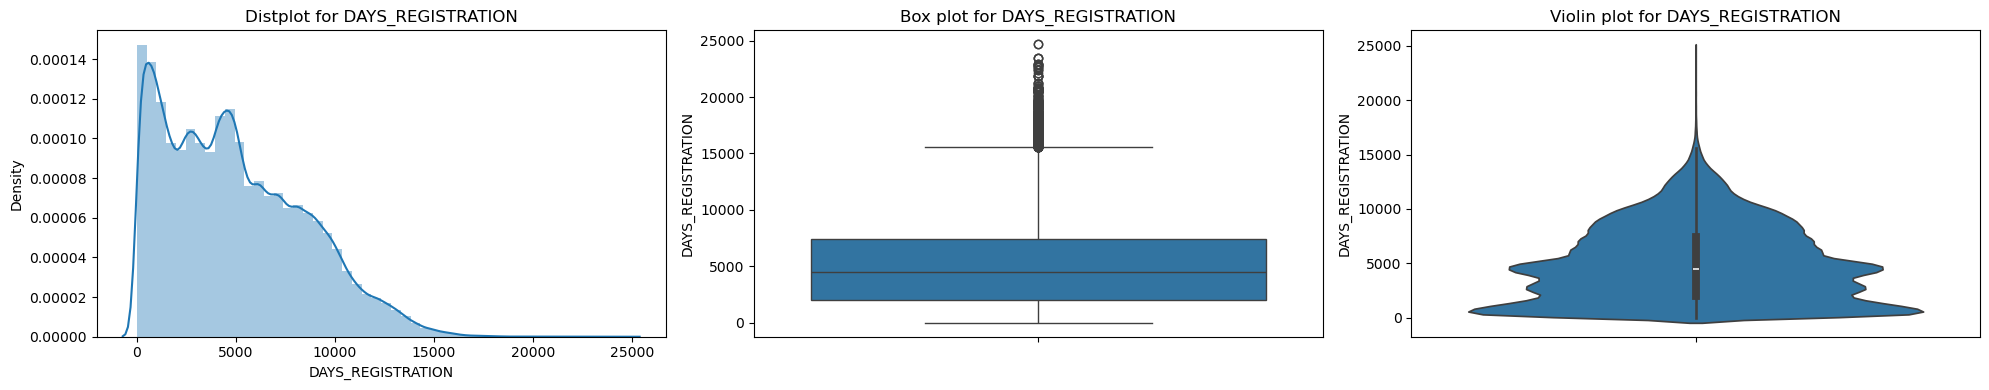

/var/folders/7d/hppk4q955wx8kcl4r2ll10dm0000gn/T/ipykernel_89194/1201161540.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)


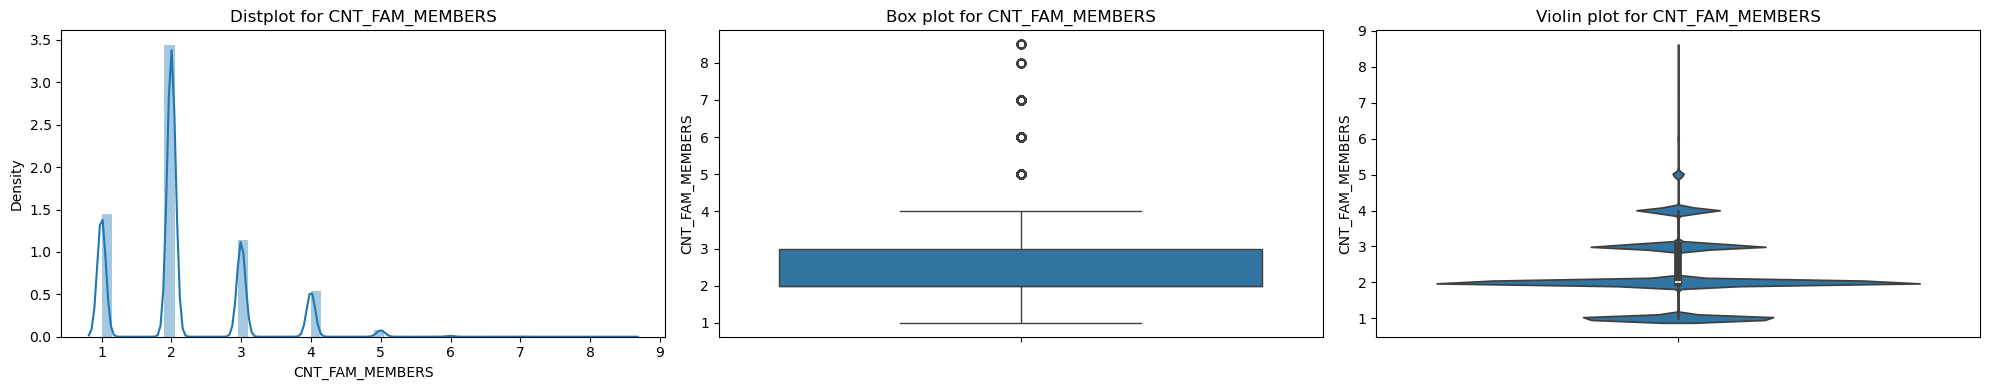

/var/folders/7d/hppk4q955wx8kcl4r2ll10dm0000gn/T/ipykernel_89194/1201161540.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)


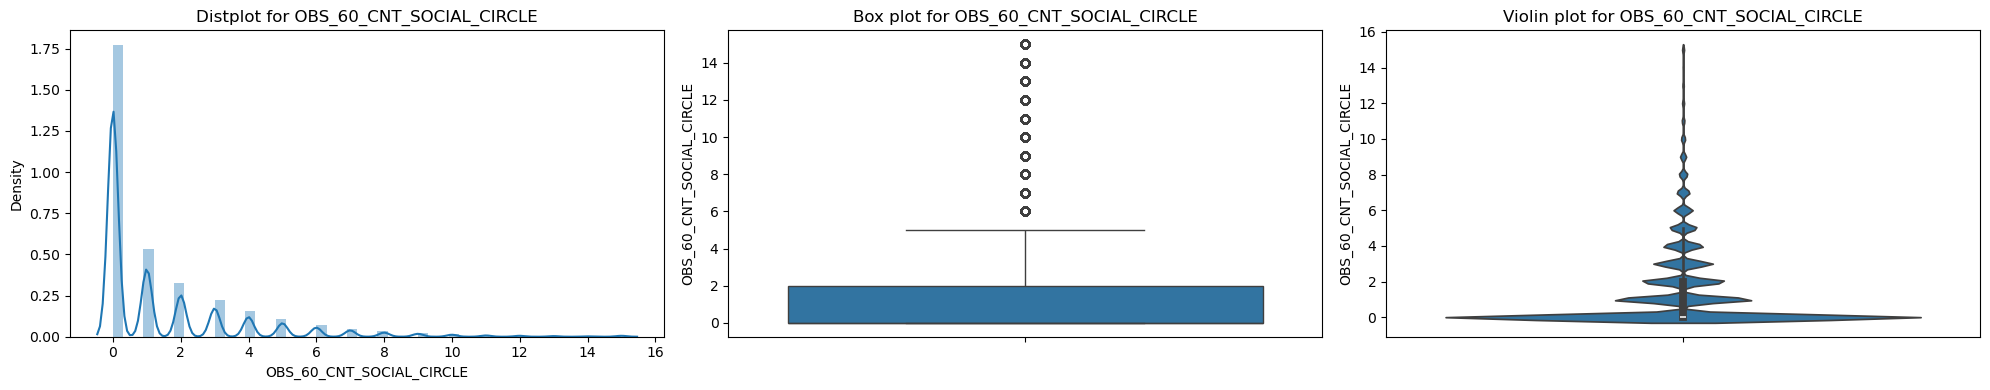

/var/folders/7d/hppk4q955wx8kcl4r2ll10dm0000gn/T/ipykernel_89194/1201161540.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)


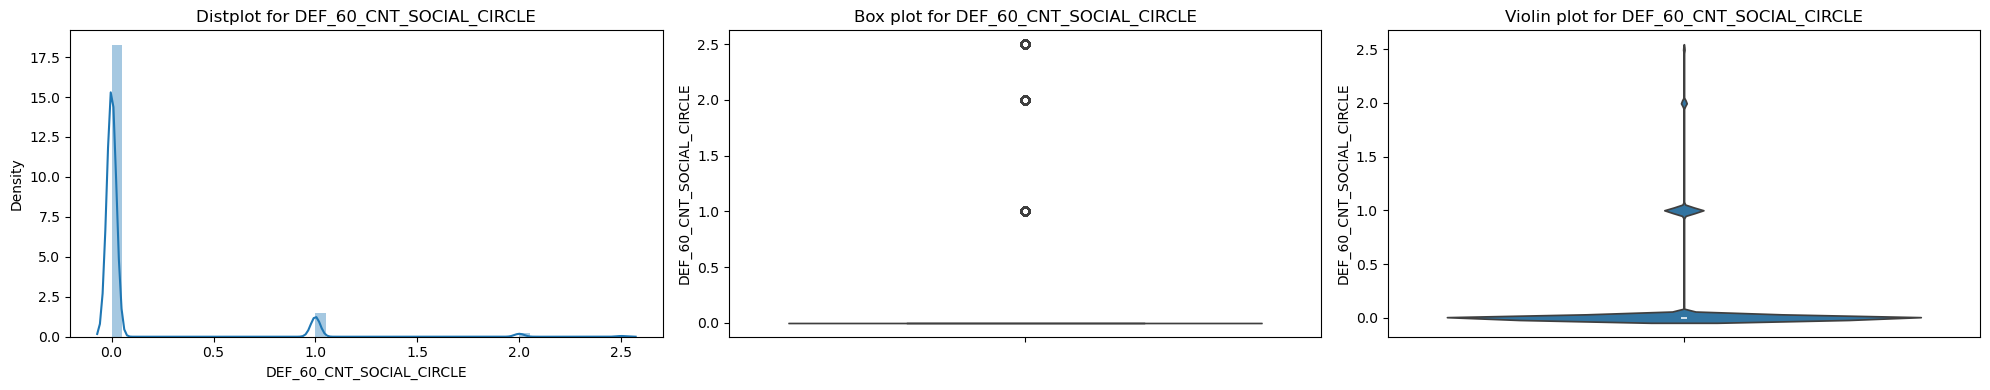

/var/folders/7d/hppk4q955wx8kcl4r2ll10dm0000gn/T/ipykernel_89194/1201161540.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)


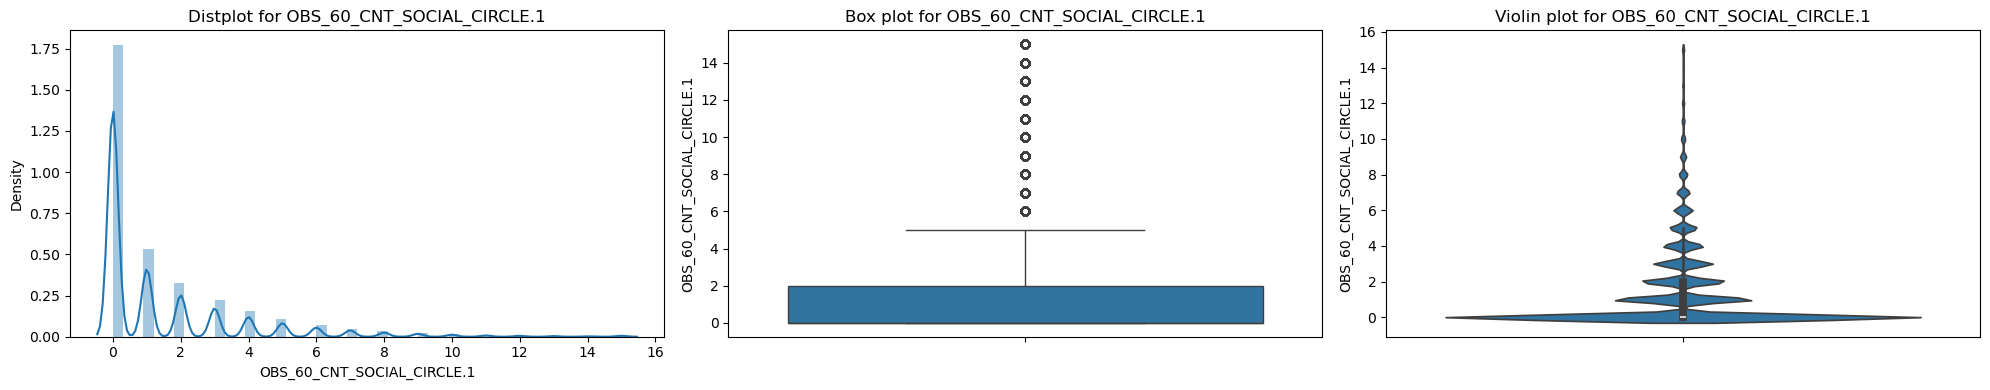

/var/folders/7d/hppk4q955wx8kcl4r2ll10dm0000gn/T/ipykernel_89194/1201161540.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)


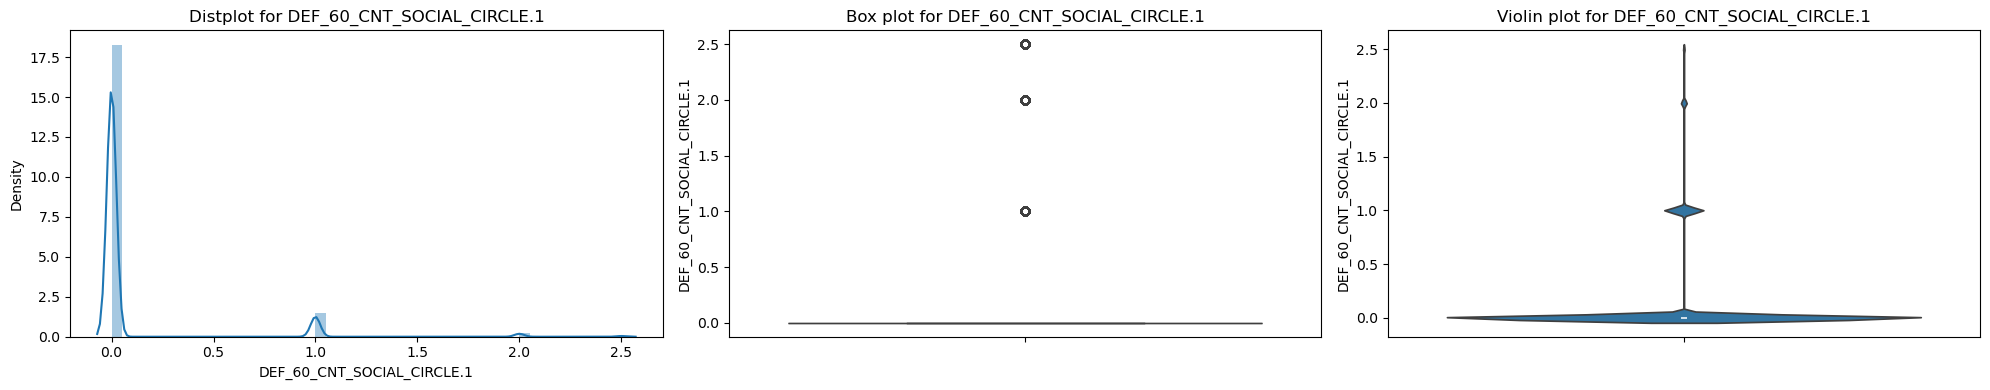

/var/folders/7d/hppk4q955wx8kcl4r2ll10dm0000gn/T/ipykernel_89194/1201161540.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)
/Users/allen/anaconda3/lib/python3.11/site-packages/seaborn/distributions.py:2496: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


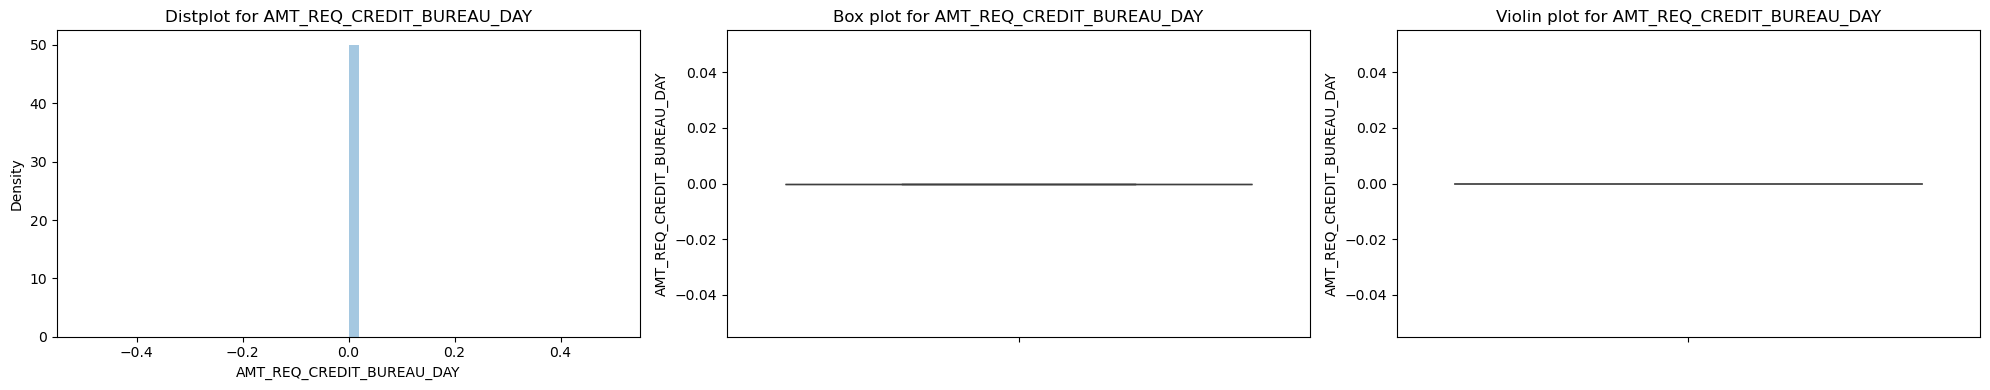

/var/folders/7d/hppk4q955wx8kcl4r2ll10dm0000gn/T/ipykernel_89194/1201161540.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)


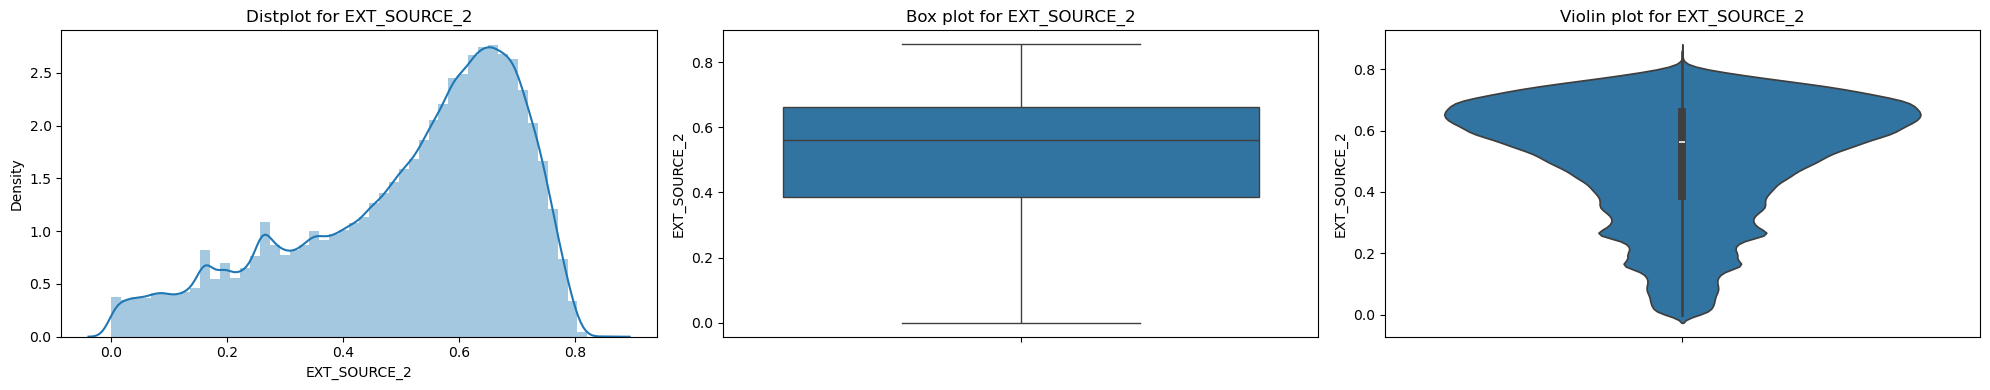

/var/folders/7d/hppk4q955wx8kcl4r2ll10dm0000gn/T/ipykernel_89194/1201161540.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)


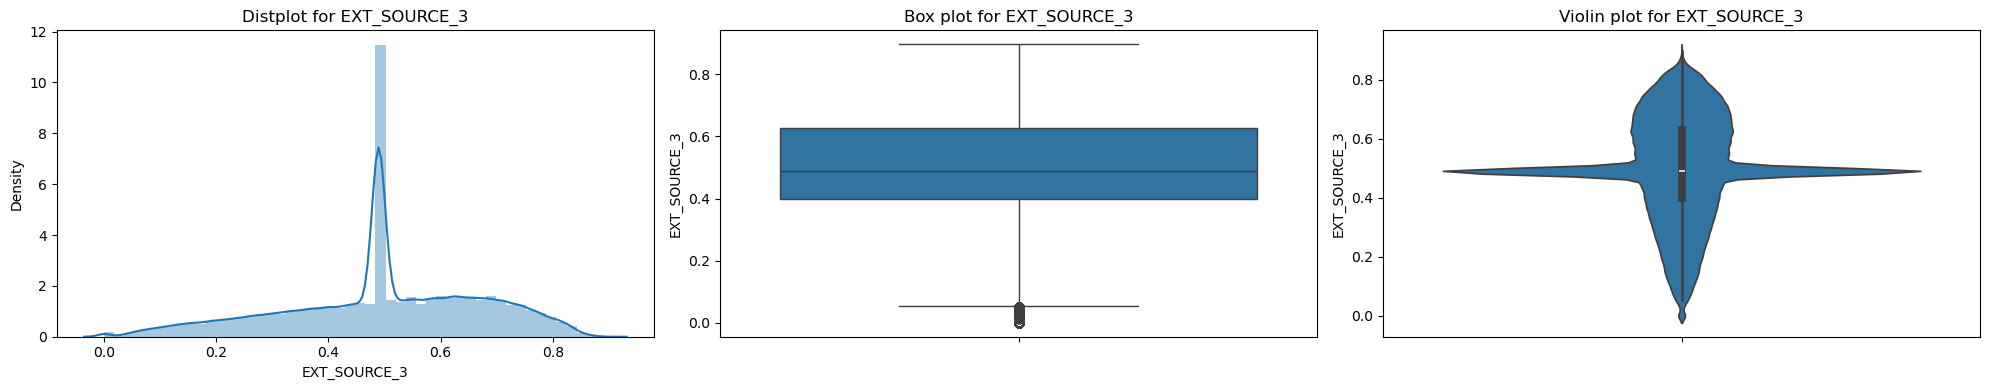

/var/folders/7d/hppk4q955wx8kcl4r2ll10dm0000gn/T/ipykernel_89194/1201161540.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)


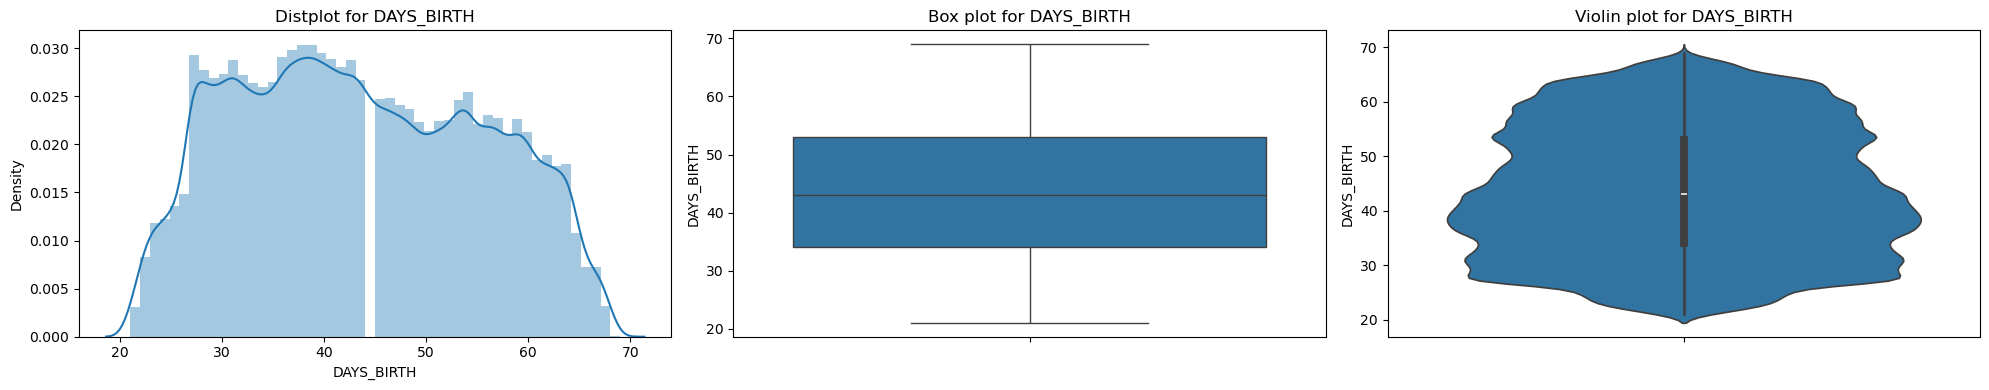

/var/folders/7d/hppk4q955wx8kcl4r2ll10dm0000gn/T/ipykernel_89194/1201161540.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)


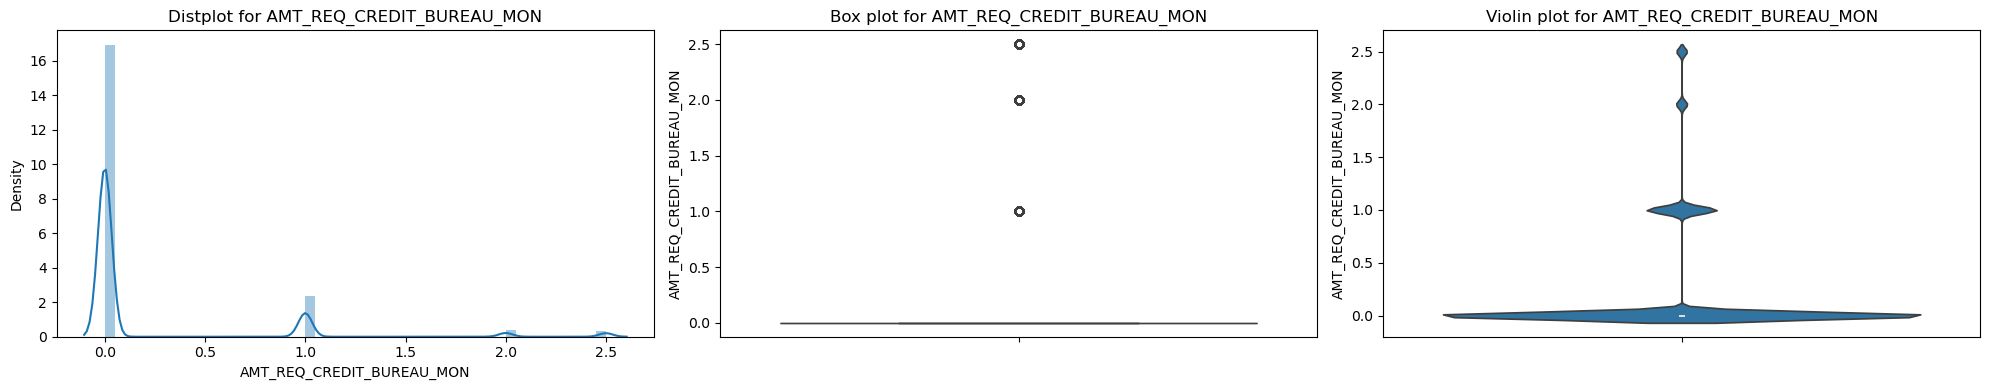

/var/folders/7d/hppk4q955wx8kcl4r2ll10dm0000gn/T/ipykernel_89194/1201161540.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)


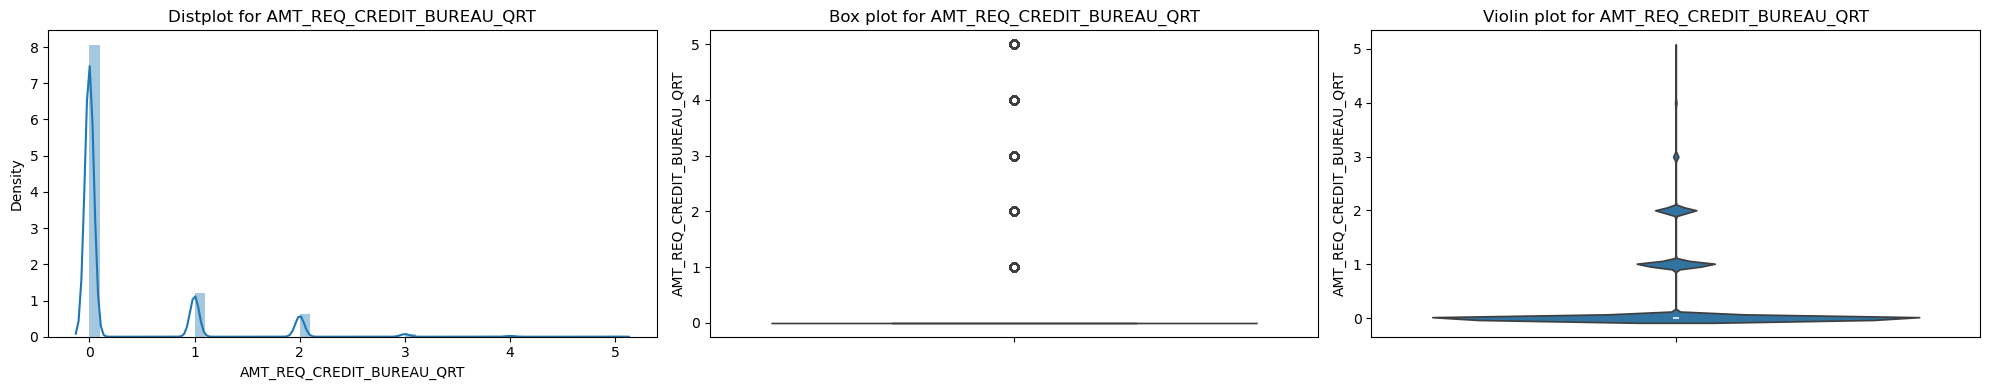

/var/folders/7d/hppk4q955wx8kcl4r2ll10dm0000gn/T/ipykernel_89194/1201161540.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)


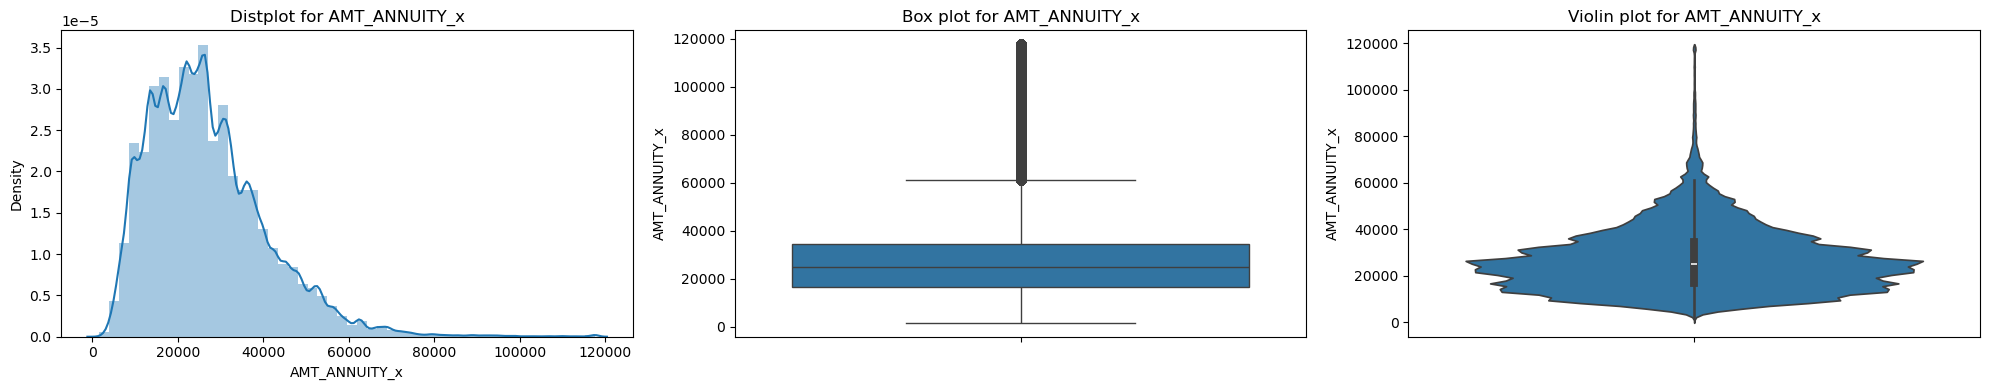

/var/folders/7d/hppk4q955wx8kcl4r2ll10dm0000gn/T/ipykernel_89194/1201161540.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)


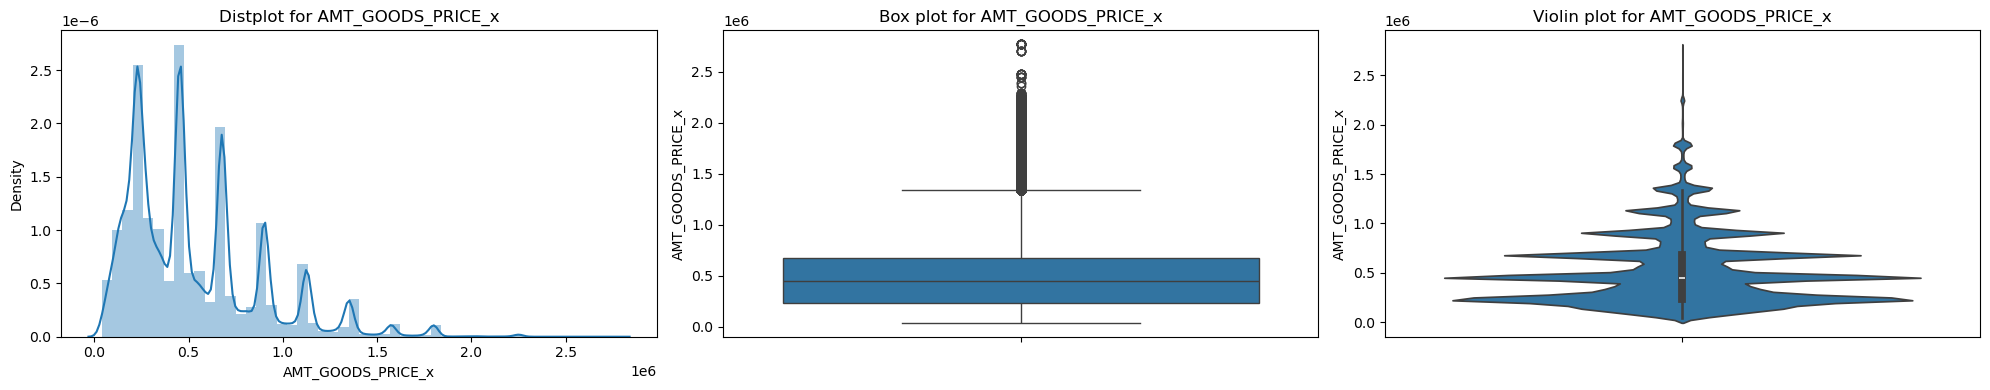

In [88]:
for col in num_cols:
    #print(col,check_outlier(df,col))
    skewplot(df,col)

In [13]:
#Edit Inplace
for col in num_cols:
    if(check_outlier(df,col)):
        replace_with_thresholds(df,col)

In [14]:
for col in num_cols:
    print(col,check_outlier(df,col))

SK_ID_CURR False
AMT_CREDIT_x False
AMT_INCOME_TOTAL False
CREDIT_INCOME_RATIO False
DAYS_EMPLOYED False
DAYS_REGISTRATION False
CNT_FAM_MEMBERS False
OBS_60_CNT_SOCIAL_CIRCLE False
DEF_60_CNT_SOCIAL_CIRCLE False
OBS_60_CNT_SOCIAL_CIRCLE.1 False
DEF_60_CNT_SOCIAL_CIRCLE.1 False
AMT_REQ_CREDIT_BUREAU_DAY False
EXT_SOURCE_2 False
EXT_SOURCE_3 False
DAYS_BIRTH False
AMT_REQ_CREDIT_BUREAU_MON False
AMT_REQ_CREDIT_BUREAU_QRT False
AMT_ANNUITY_x False
AMT_GOODS_PRICE_x False


In [15]:
cat_cols

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'AMT_ANNUITY_RANGE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'NAME_CONTRACT_STATUS',
 'NAME_CLIENT_TYPE',
 'NAME_CONTRACT_TYPE_x',
 'EMPLOYMENT_YEAR']

In [16]:
a = pd.get_dummies(df,columns= cat_cols, drop_first= False)

In [17]:
a

,SK_ID_CURR,TARGET,AMT_CREDIT_x,AMT_INCOME_TOTAL,CREDIT_INCOME_RATIO,DAYS_EMPLOYED,DAYS_REGISTRATION,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,...,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_CONTRACT_TYPE_x_Cash loans,NAME_CONTRACT_TYPE_x_Revolving loans,EMPLOYMENT_YEAR_0-5Y,EMPLOYMENT_YEAR_10-20Y,EMPLOYMENT_YEAR_20-30Y,EMPLOYMENT_YEAR_30-40Y,EMPLOYMENT_YEAR_40-50Y,EMPLOYMENT_YEAR_5-10Y
0,100002,1,406597.5,202500.0,2.0,637,3648.0,0,1.0,2,...,False,False,True,False,True,False,False,False,False,False
1,100003,0,1293502.5,270000.0,5.0,1188,1186.0,0,2.0,1,...,True,False,True,False,True,False,False,False,False,False
2,100003,0,1293502.5,270000.0,5.0,1188,1186.0,0,2.0,1,...,False,False,True,False,True,False,False,False,False,False
3,100004,0,135000.0,67500.0,2.0,225,4260.0,0,1.0,2,...,False,False,False,True,True,False,False,False,False,False
4,100006,0,312682.5,135000.0,2.0,3039,9833.0,0,2.0,2,...,True,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743149,456254,1,370107.0,171000.0,2.0,4786,2562.0,0,2.0,2,...,True,False,True,False,False,True,False,False,False,False
743150,456254,1,370107.0,171000.0,2.0,4786,2562.0,0,2.0,2,...,False,False,True,False,False,True,False,False,False,False
743151,456255,0,675000.0,157500.0,4.0,1262,5128.0,0,2.0,1,...,False,False,True,False,True,False,False,False,False,False
743152,456255,0,675000.0,157500.0,4.0,1262,5128.0,0,2.0,1,...,True,False,True,False,True,False,False,False,False,False


In [18]:
#Encoding Categorical Variables
df["CODE_GENDER"] =  df['CODE_GENDER'].replace(['F','M'],[0,1])
df["FLAG_OWN_CAR"] = df["FLAG_OWN_CAR"].replace(["Y","N"],[1,0])
df["FLAG_OWN_REALTY"] = df["FLAG_OWN_REALTY"].replace(["Y","N"],[1,0])

/var/folders/7d/hppk4q955wx8kcl4r2ll10dm0000gn/T/ipykernel_89194/2702191399.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["CODE_GENDER"] =  df['CODE_GENDER'].replace(['F','M'],[0,1])
/var/folders/7d/hppk4q955wx8kcl4r2ll10dm0000gn/T/ipykernel_89194/2702191399.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["FLAG_OWN_CAR"] = df["FLAG_OWN_CAR"].replace(["Y","N"],[1,0])
/var/folders/7d/hppk4q955wx8kcl4r2ll10dm0000gn/T/ipykernel_89194/2702191399.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and wi

In [20]:
# Checking correlation on Numerical Columns

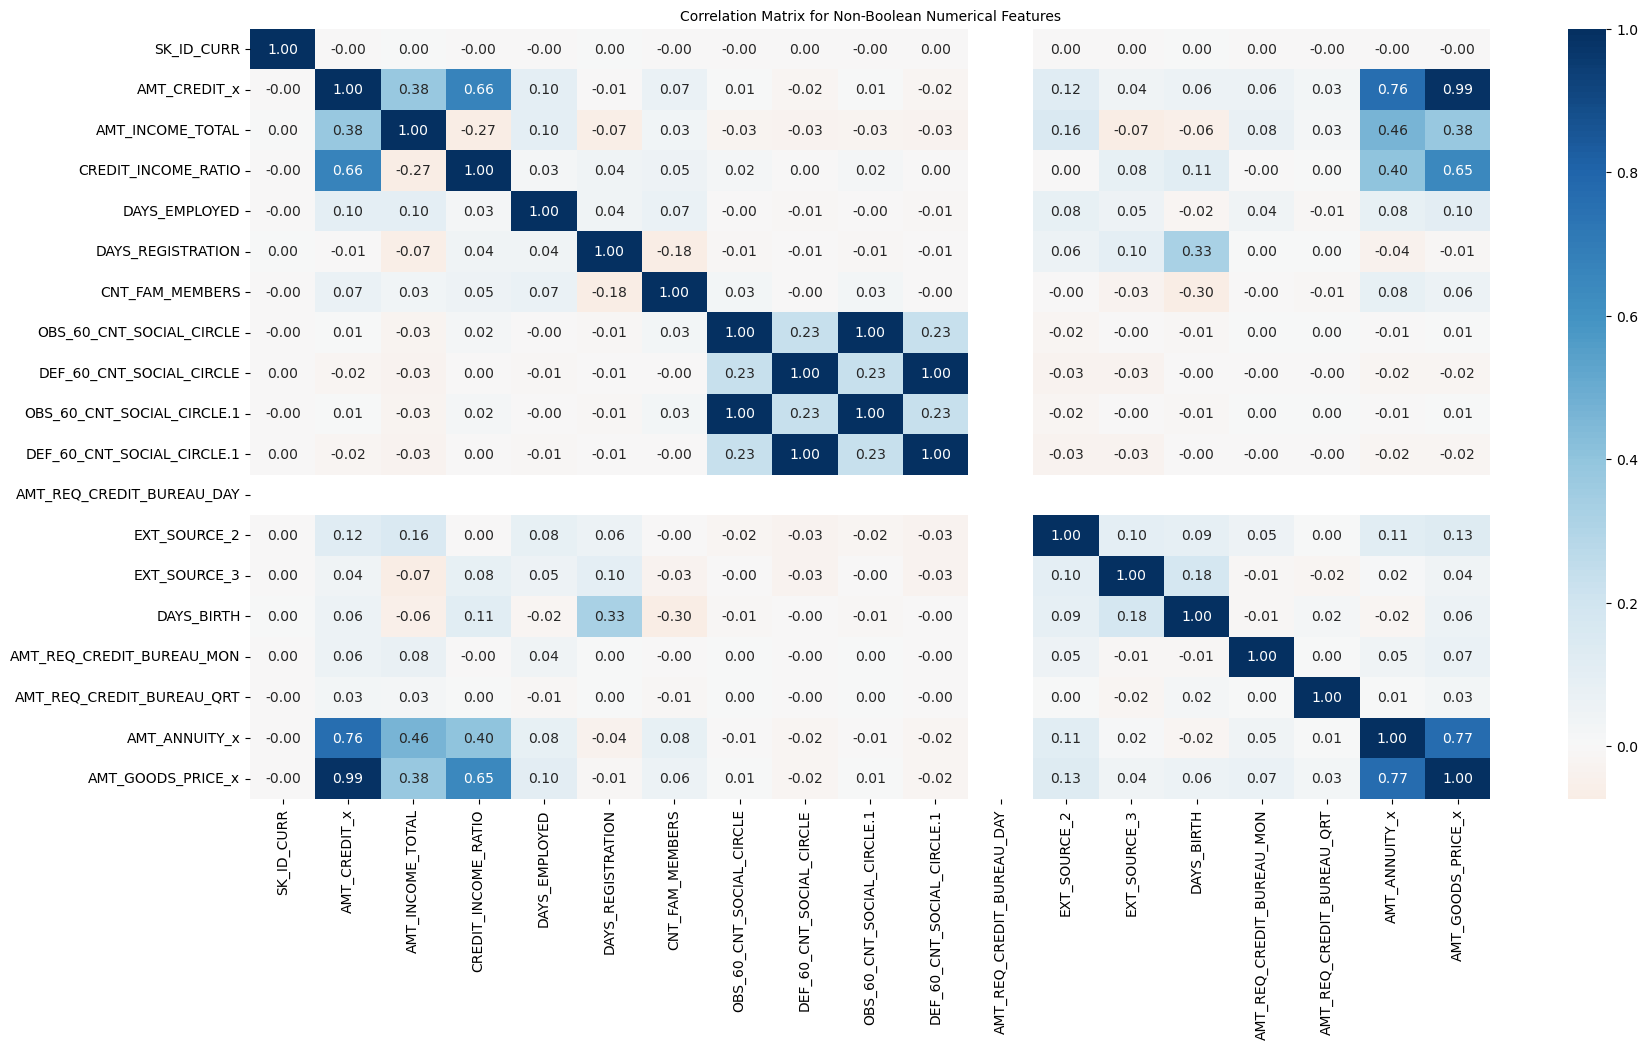

In [21]:
df_corr = df[num_cols].corr()
plt.figure(figsize=(20,10))
sns.heatmap(df_corr, annot=True, fmt=".2f", center=0, robust= True,
            cmap='RdBu',)
    
plt.title('Correlation Matrix for Non-Boolean Numerical Features', fontsize=10)
plt.show()

In [22]:
df

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_ANNUITY_RANGE,AMT_CREDIT_x,AMT_INCOME_TOTAL,CREDIT_INCOME_RATIO,NAME_INCOME_TYPE,...,NAME_CONTRACT_STATUS,NAME_CLIENT_TYPE,DAYS_BIRTH,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,NAME_CONTRACT_TYPE_x,AMT_ANNUITY_x,REGION_RATING_CLIENT,AMT_GOODS_PRICE_x,EMPLOYMENT_YEAR
0,100002,1,1,0,1,20-30Y,406597.5,202500.0,2.0,Working,...,Approved,New,9461,0.0,0.0,Cash loans,24700.5,2,351000.0,0-5Y
1,100003,0,0,0,0,30-40Y,1293502.5,270000.0,5.0,State servant,...,Approved,Repeater,16765,0.0,0.0,Cash loans,35698.5,1,1129500.0,0-5Y
2,100003,0,0,0,0,30-40Y,1293502.5,270000.0,5.0,State servant,...,Approved,Refreshed,16765,0.0,0.0,Cash loans,35698.5,1,1129500.0,0-5Y
3,100004,0,1,1,1,5-10Y,135000.0,67500.0,2.0,Working,...,Approved,New,19046,0.0,0.0,Revolving loans,6750.0,2,135000.0,0-5Y
4,100006,0,0,0,1,20-30Y,312682.5,135000.0,2.0,Working,...,Approved,Repeater,19005,0.0,0.0,Cash loans,29686.5,2,297000.0,5-10Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743149,456254,1,0,0,1,20-30Y,370107.0,171000.0,2.0,Commercial associate,...,Approved,Repeater,11961,0.0,0.0,Cash loans,20205.0,2,319500.0,10-20Y
743150,456254,1,0,0,1,20-30Y,370107.0,171000.0,2.0,Commercial associate,...,Approved,New,11961,0.0,0.0,Cash loans,20205.0,2,319500.0,10-20Y
743151,456255,0,0,0,0,40-50Y,675000.0,157500.0,4.0,Commercial associate,...,Approved,Refreshed,16856,2.0,0.0,Cash loans,49117.5,1,675000.0,0-5Y
743152,456255,0,0,0,0,40-50Y,675000.0,157500.0,4.0,Commercial associate,...,Approved,Repeater,16856,2.0,0.0,Cash loans,49117.5,1,675000.0,0-5Y


In [23]:
df.DAYS_BIRTH =  df.DAYS_BIRTH.apply(lambda x: x // 365)
bins = [21, 34, 45, 57, 69]
labels = ['21-33', '34-45', '46-57', '58-69']
df['AGE_CATEGORY'] = pd.cut(df['DAYS_BIRTH'], bins=bins, labels=labels, include_lowest=True)

In [24]:
df.AGE_CATEGORY

0         21-33
1         34-45
2         34-45
3         46-57
4         46-57
          ...  
743149    21-33
743150    21-33
743151    46-57
743152    46-57
743153    46-57
Name: AGE_CATEGORY, Length: 743154, dtype: category
Categories (4, object): ['21-33' < '34-45' < '46-57' < '58-69']

In [25]:
df.isnull().sum()

SK_ID_CURR                     0
TARGET                         0
CODE_GENDER                    0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
AMT_ANNUITY_RANGE              0
AMT_CREDIT_x                   0
AMT_INCOME_TOTAL               0
CREDIT_INCOME_RATIO            0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
NAME_FAMILY_STATUS             0
NAME_HOUSING_TYPE              0
DAYS_EMPLOYED                  0
DAYS_REGISTRATION              0
FLAG_EMAIL                     0
OCCUPATION_TYPE                0
CNT_FAM_MEMBERS                0
REGION_RATING_CLIENT_W_CITY    0
ORGANIZATION_TYPE              0
OBS_60_CNT_SOCIAL_CIRCLE       0
DEF_60_CNT_SOCIAL_CIRCLE       0
OBS_60_CNT_SOCIAL_CIRCLE.1     0
DEF_60_CNT_SOCIAL_CIRCLE.1     0
AMT_REQ_CREDIT_BUREAU_DAY      0
EXT_SOURCE_2                   0
EXT_SOURCE_3                   0
Total_Documents                0
NAME_CONTRACT_STATUS           0
NAME_CLIENT_TYPE               0
DAYS_BIRTH

In [26]:
df.dropna(inplace= True) #Deleting data of AGE Category null values

In [27]:
df.shape

(743151, 39)

In [28]:
df['INCOME_CATEGORY'] = pd.qcut(df['AMT_INCOME_TOTAL'], q=4, labels=['Low', 'Medium', 'High','Very High'])

In [29]:
bins_1 = pd.qcut(df['AMT_INCOME_TOTAL'], q=4)

In [30]:
bins_1

0          (157500.0, 202500.0]
1          (202500.0, 720000.0]
2          (202500.0, 720000.0]
3         (25649.999, 112500.0]
4          (112500.0, 157500.0]
                  ...          
743149     (157500.0, 202500.0]
743150     (157500.0, 202500.0]
743151     (112500.0, 157500.0]
743152     (112500.0, 157500.0]
743153     (112500.0, 157500.0]
Name: AMT_INCOME_TOTAL, Length: 743151, dtype: category
Categories (4, interval[float64, right]): [(25649.999, 112500.0] < (112500.0, 157500.0] < (157500.0, 202500.0] < (202500.0, 720000.0]]

In [31]:
df.AMT_INCOME_TOTAL.min()

25650.0

In [32]:
df['INCOME_CATEGORY'][0]

'High'

In [33]:
df.isnull().sum()

SK_ID_CURR                     0
TARGET                         0
CODE_GENDER                    0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
AMT_ANNUITY_RANGE              0
AMT_CREDIT_x                   0
AMT_INCOME_TOTAL               0
CREDIT_INCOME_RATIO            0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
NAME_FAMILY_STATUS             0
NAME_HOUSING_TYPE              0
DAYS_EMPLOYED                  0
DAYS_REGISTRATION              0
FLAG_EMAIL                     0
OCCUPATION_TYPE                0
CNT_FAM_MEMBERS                0
REGION_RATING_CLIENT_W_CITY    0
ORGANIZATION_TYPE              0
OBS_60_CNT_SOCIAL_CIRCLE       0
DEF_60_CNT_SOCIAL_CIRCLE       0
OBS_60_CNT_SOCIAL_CIRCLE.1     0
DEF_60_CNT_SOCIAL_CIRCLE.1     0
AMT_REQ_CREDIT_BUREAU_DAY      0
EXT_SOURCE_2                   0
EXT_SOURCE_3                   0
Total_Documents                0
NAME_CONTRACT_STATUS           0
NAME_CLIENT_TYPE               0
DAYS_BIRTH

In [34]:
df.AMT_INCOME_TOTAL

0         202500.0
1         270000.0
2         270000.0
3          67500.0
4         135000.0
            ...   
743149    171000.0
743150    171000.0
743151    157500.0
743152    157500.0
743153    157500.0
Name: AMT_INCOME_TOTAL, Length: 743151, dtype: float64

In [35]:
len(df.columns)

40

In [36]:
# Defining feature interaction for OCCUPATION_TYPE and houstp variables
df.loc[(df['OCCUPATION_TYPE']=='Cleaning staff') | (df['OCCUPATION_TYPE']=='Cooking staff') | (df['OCCUPATION_TYPE']=='Drivers') |
       (df['OCCUPATION_TYPE']=='Laborers') | (df['OCCUPATION_TYPE']=='Low-skill Laborers') | (df['OCCUPATION_TYPE']=='Security staff') |
       (df['OCCUPATION_TYPE']=='Waiters/barmen staff') ,'OCCUPATION_TYPE']='Laborwk'


df.loc[(df['OCCUPATION_TYPE']=='Accountants') | (df['OCCUPATION_TYPE']=='Core staff') | (df['OCCUPATION_TYPE']=='HR staff') |
       (df['OCCUPATION_TYPE']=='Medicine staff') | (df['OCCUPATION_TYPE']=='Private service staff') | (df['OCCUPATION_TYPE']=='Realty agents') |
       (df['OCCUPATION_TYPE']=='Sales staff') | (df['OCCUPATION_TYPE']=='Secretaries'),'OCCUPATION_TYPE']='officewk'

df.loc[(df['OCCUPATION_TYPE']=='Managers') | (df['OCCUPATION_TYPE']=='High skill tech staff') | (df['OCCUPATION_TYPE']=='IT staff'),'OCCUPATION_TYPE']='hightecwk'

In [37]:
housing_type = {'House / apartment' : 'House / apartment',
                   'With parents': 'With parents',
                    'Municipal apartment' : 'House / apartment',
                    'Rented apartment': 'House / apartment',
                    'Office apartment': 'House / apartment',
                    'Co-op apartment': 'House / apartment'}
df["NAME_HOUSING_TYPE"] = df['NAME_HOUSING_TYPE'].map(housing_type)

/Users/allen/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/allen/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


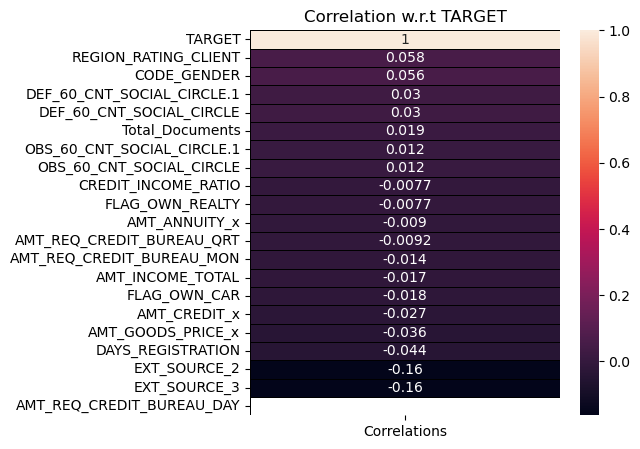

In [38]:
#  - Correlation Analysis

corr = df[['TARGET','CODE_GENDER','AMT_CREDIT_x','AMT_INCOME_TOTAL','DEF_60_CNT_SOCIAL_CIRCLE',
          'OBS_60_CNT_SOCIAL_CIRCLE.1','DEF_60_CNT_SOCIAL_CIRCLE.1','AMT_REQ_CREDIT_BUREAU_DAY',
          'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_ANNUITY_x',
          'AMT_GOODS_PRICE_x','DAYS_REGISTRATION','OBS_60_CNT_SOCIAL_CIRCLE',
          'FLAG_OWN_REALTY','REGION_RATING_CLIENT','FLAG_OWN_CAR','CREDIT_INCOME_RATIO','EXT_SOURCE_2',
           'EXT_SOURCE_3','Total_Documents']].corrwith(df['TARGET']).sort_values(ascending = False).to_frame()

corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,linewidths = 0.4,linecolor = 'black')
plt.title('Correlation w.r.t TARGET')
plt.show(block=True)



In [39]:
df.AMT_REQ_CREDIT_BUREAU_MON.value_counts()

AMT_REQ_CREDIT_BUREAU_MON
0.0    628447
1.0     87680
2.0     13874
2.5     13150
Name: count, dtype: int64

In [40]:
df.isna().sum()

SK_ID_CURR                     0
TARGET                         0
CODE_GENDER                    0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
AMT_ANNUITY_RANGE              0
AMT_CREDIT_x                   0
AMT_INCOME_TOTAL               0
CREDIT_INCOME_RATIO            0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
NAME_FAMILY_STATUS             0
NAME_HOUSING_TYPE              0
DAYS_EMPLOYED                  0
DAYS_REGISTRATION              0
FLAG_EMAIL                     0
OCCUPATION_TYPE                0
CNT_FAM_MEMBERS                0
REGION_RATING_CLIENT_W_CITY    0
ORGANIZATION_TYPE              0
OBS_60_CNT_SOCIAL_CIRCLE       0
DEF_60_CNT_SOCIAL_CIRCLE       0
OBS_60_CNT_SOCIAL_CIRCLE.1     0
DEF_60_CNT_SOCIAL_CIRCLE.1     0
AMT_REQ_CREDIT_BUREAU_DAY      0
EXT_SOURCE_2                   0
EXT_SOURCE_3                   0
Total_Documents                0
NAME_CONTRACT_STATUS           0
NAME_CLIENT_TYPE               0
DAYS_BIRTH

In [41]:
df.NAME_CONTRACT_STATUS.value_counts()

NAME_CONTRACT_STATUS
Approved        503847
Canceled        113533
Refused         106312
Unused offer     19459
Name: count, dtype: int64

In [42]:
df.isna().sum()

SK_ID_CURR                     0
TARGET                         0
CODE_GENDER                    0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
AMT_ANNUITY_RANGE              0
AMT_CREDIT_x                   0
AMT_INCOME_TOTAL               0
CREDIT_INCOME_RATIO            0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
NAME_FAMILY_STATUS             0
NAME_HOUSING_TYPE              0
DAYS_EMPLOYED                  0
DAYS_REGISTRATION              0
FLAG_EMAIL                     0
OCCUPATION_TYPE                0
CNT_FAM_MEMBERS                0
REGION_RATING_CLIENT_W_CITY    0
ORGANIZATION_TYPE              0
OBS_60_CNT_SOCIAL_CIRCLE       0
DEF_60_CNT_SOCIAL_CIRCLE       0
OBS_60_CNT_SOCIAL_CIRCLE.1     0
DEF_60_CNT_SOCIAL_CIRCLE.1     0
AMT_REQ_CREDIT_BUREAU_DAY      0
EXT_SOURCE_2                   0
EXT_SOURCE_3                   0
Total_Documents                0
NAME_CONTRACT_STATUS           0
NAME_CLIENT_TYPE               0
DAYS_BIRTH

In [43]:
df.INCOME_CATEGORY

0              High
1         Very High
2         Very High
3               Low
4            Medium
            ...    
743149         High
743150         High
743151       Medium
743152       Medium
743153       Medium
Name: INCOME_CATEGORY, Length: 743151, dtype: category
Categories (4, object): ['Low' < 'Medium' < 'High' < 'Very High']

# Feature Selection


In [44]:
final_col = ['CODE_GENDER', 'FLAG_OWN_REALTY', 'EMPLOYMENT_YEAR','AMT_INCOME_TOTAL','Total_Documents',
             'DAYS_REGISTRATION','DEF_60_CNT_SOCIAL_CIRCLE','AMT_REQ_CREDIT_BUREAU_MON','AMT_ANNUITY_x',
             'EXT_SOURCE_3', 'FLAG_OWN_CAR','REGION_RATING_CLIENT','TARGET','AMT_CREDIT_x','AGE_CATEGORY','INCOME_CATEGORY']
X = df[final_col]
X = X.drop('TARGET', axis = 1)
y = df['TARGET']
df[final_col].isna().sum()

CODE_GENDER                  0
FLAG_OWN_REALTY              0
EMPLOYMENT_YEAR              0
AMT_INCOME_TOTAL             0
Total_Documents              0
DAYS_REGISTRATION            0
DEF_60_CNT_SOCIAL_CIRCLE     0
AMT_REQ_CREDIT_BUREAU_MON    0
AMT_ANNUITY_x                0
EXT_SOURCE_3                 0
FLAG_OWN_CAR                 0
REGION_RATING_CLIENT         0
TARGET                       0
AMT_CREDIT_x                 0
AGE_CATEGORY                 0
INCOME_CATEGORY              0
dtype: int64

In [45]:
X[['AMT_INCOME_TOTAL','DAYS_REGISTRATION','AMT_ANNUITY_x','EXT_SOURCE_3','AMT_CREDIT_x']]

,AMT_INCOME_TOTAL,DAYS_REGISTRATION,AMT_ANNUITY_x,EXT_SOURCE_3,AMT_CREDIT_x
0,202500.0,3648.0,24700.5,0.139376,406597.5
1,270000.0,1186.0,35698.5,0.489699,1293502.5
2,270000.0,1186.0,35698.5,0.489699,1293502.5
3,67500.0,4260.0,6750.0,0.729567,135000.0
4,135000.0,9833.0,29686.5,0.489699,312682.5
...,...,...,...,...,...
743149,171000.0,2562.0,20205.0,0.661024,370107.0
743150,171000.0,2562.0,20205.0,0.661024,370107.0
743151,157500.0,5128.0,49117.5,0.113922,675000.0
743152,157500.0,5128.0,49117.5,0.113922,675000.0


In [46]:
X.head()

,CODE_GENDER,FLAG_OWN_REALTY,EMPLOYMENT_YEAR,AMT_INCOME_TOTAL,Total_Documents,DAYS_REGISTRATION,DEF_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_MON,AMT_ANNUITY_x,EXT_SOURCE_3,FLAG_OWN_CAR,REGION_RATING_CLIENT,AMT_CREDIT_x,AGE_CATEGORY,INCOME_CATEGORY
0,1,1,0-5Y,202500.0,1,3648.0,2.0,0.0,24700.5,0.139376,0,2,406597.5,21-33,High
1,0,0,0-5Y,270000.0,1,1186.0,0.0,0.0,35698.5,0.489699,0,1,1293502.5,34-45,Very High
2,0,0,0-5Y,270000.0,1,1186.0,0.0,0.0,35698.5,0.489699,0,1,1293502.5,34-45,Very High
3,1,1,0-5Y,67500.0,0,4260.0,0.0,0.0,6750.0,0.729567,1,2,135000.0,46-57,Low
4,0,1,5-10Y,135000.0,1,9833.0,0.0,0.0,29686.5,0.489699,0,2,312682.5,46-57,Medium


In [47]:
len(final_col)

16

In [48]:
'''
def one_hot_encoder(df, cat_cols, drop_first=False):
    df = pd.get_dummies(df, columns = cat_cols, drop_first=drop_first)
    return df
'''
    

'\ndef one_hot_encoder(df, cat_cols, drop_first=False):\n    df = pd.get_dummies(df, columns = cat_cols, drop_first=drop_first)\n    return df\n'

In [49]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X[['EMPLOYMENT_YEAR','AGE_CATEGORY','INCOME_CATEGORY']])
X_ohe = ohe.fit_transform(X[['EMPLOYMENT_YEAR', 'AGE_CATEGORY','INCOME_CATEGORY']]).toarray()

In [50]:
#print(len(X[0]))

In [51]:
grab_col_names(X)

Observations: 743151
Variables: 15
cat_cols: 1
num_cols: 5
num_but_cat: 9


(['EMPLOYMENT_YEAR'],
 ['AMT_INCOME_TOTAL',
  'DAYS_REGISTRATION',
  'AMT_ANNUITY_x',
  'EXT_SOURCE_3',
  'AMT_CREDIT_x'],
 ['CODE_GENDER',
  'FLAG_OWN_REALTY',
  'Total_Documents',
  'DEF_60_CNT_SOCIAL_CIRCLE',
  'AMT_REQ_CREDIT_BUREAU_MON',
  'FLAG_OWN_CAR',
  'REGION_RATING_CLIENT',
  'AGE_CATEGORY',
  'INCOME_CATEGORY'])

In [52]:
df.REGION_RATING_CLIENT.value_counts()

REGION_RATING_CLIENT
2    552574
3    118465
1     72112
Name: count, dtype: int64

In [53]:
'''
cat_cols, num_cols,num_but_cat = grab_col_names(X)


X = one_hot_encoder(X, cat_cols, drop_first=True)
X.head()
'''

'\ncat_cols, num_cols,num_but_cat = grab_col_names(X)\n\n\nX = one_hot_encoder(X, cat_cols, drop_first=True)\nX.head()\n'

In [54]:
#X.drop_duplicates(inplace= True)

In [55]:
grab_col_names(X)

Observations: 743151
Variables: 15
cat_cols: 1
num_cols: 5
num_but_cat: 9


(['EMPLOYMENT_YEAR'],
 ['AMT_INCOME_TOTAL',
  'DAYS_REGISTRATION',
  'AMT_ANNUITY_x',
  'EXT_SOURCE_3',
  'AMT_CREDIT_x'],
 ['CODE_GENDER',
  'FLAG_OWN_REALTY',
  'Total_Documents',
  'DEF_60_CNT_SOCIAL_CIRCLE',
  'AMT_REQ_CREDIT_BUREAU_MON',
  'FLAG_OWN_CAR',
  'REGION_RATING_CLIENT',
  'AGE_CATEGORY',
  'INCOME_CATEGORY'])

In [57]:
# Performing scaling for numerical variables
scaler = StandardScaler()
scaler.fit(X[['AMT_INCOME_TOTAL','DAYS_REGISTRATION','AMT_ANNUITY_x','EXT_SOURCE_3','AMT_CREDIT_x']])
X_scaled = scaler.transform(X[['AMT_INCOME_TOTAL','DAYS_REGISTRATION','AMT_ANNUITY_x','EXT_SOURCE_3','AMT_CREDIT_x']])
#X[num_cols] = X_scaled
X_scaled
scaler


StandardScaler()

In [58]:
len(X_scaled[0])

5

In [59]:

X_a = np.concatenate((X[['CODE_GENDER', 'FLAG_OWN_REALTY','Total_Documents',
             'DEF_60_CNT_SOCIAL_CIRCLE','AMT_REQ_CREDIT_BUREAU_MON',
              'FLAG_OWN_CAR','REGION_RATING_CLIENT']].values, X_scaled), axis=1)


In [83]:
X_a[0]

array([ 1.        ,  1.        ,  1.        ,  2.        ,  0.        ,
        0.        ,  2.        ,  0.38763894, -0.37502388, -0.16123803,
       -2.02345733, -0.46447194])

In [60]:
X = np.concatenate((X_a, X_ohe), axis = 1)

In [61]:
print(len(X[0]))

26


In [62]:
X_ohe

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

In [63]:
len(X_a[0])

12

In [64]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,mutual_info_classif
from sklearn.feature_selection import f_classif

/Users/allen/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/allen/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


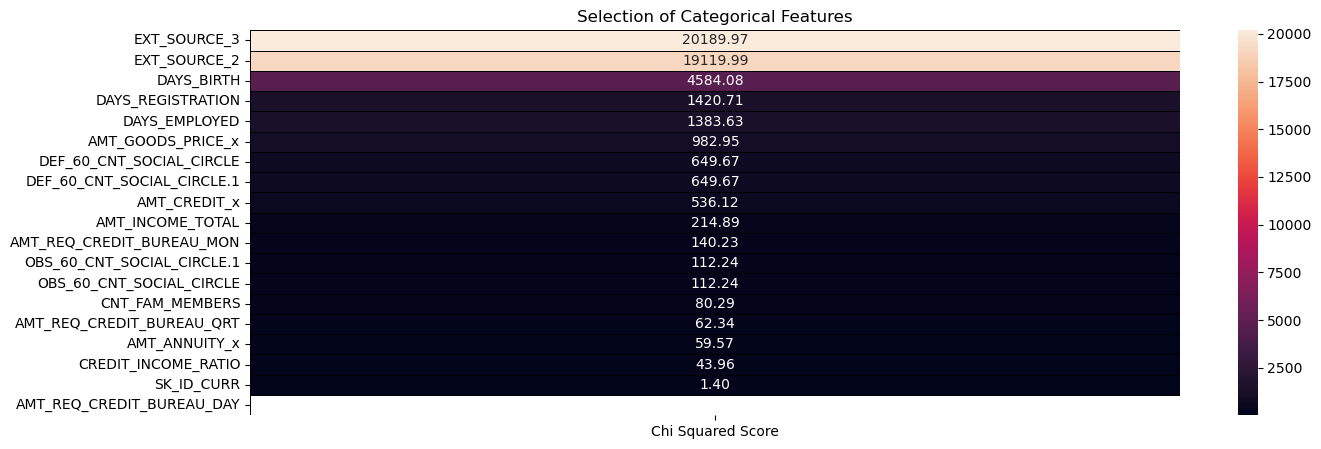

In [65]:
def score_func_by_target(variables,score,target):
    features = df.loc[:, variables]
    target = df.loc[:, target]

    best_features = SelectKBest(score_func=score, k='all')
    fit = best_features.fit(features, target)

    featureScores = pd.DataFrame(data=fit.scores_, index=list(features.columns), columns=['Chi Squared Score'])

    plt.subplots(figsize=(15, 5))
    sns.heatmap(featureScores.sort_values(ascending=False, by='Chi Squared Score'), annot=True, linewidths=0.4,
                linecolor='black', fmt='.2f');
    plt.title('Selection of Categorical Features')
    plt.show(block=True)


score_func_by_target(num_cols,f_classif,"TARGET")

In [66]:
def train_test(X, y, test_size=0.20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    print("Base Models....")
    classifiers = [  #('LR', LogisticRegression()),
        # ('KNN', KNeighborsClassifier()),
        # ("SVC", SVC()),
        ("CART", DecisionTreeClassifier(max_depth=4, random_state=0)),
        ("RF", RandomForestClassifier(random_state=0, max_features='sqrt')),
        # ('Adaboost', AdaBoostClassifier(random_state=0)),
        # ('GBM', GradientBoostingClassifier(max_depth=4,random_state=0)),
        ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
        ('LightGBM', LGBMClassifier(random_state=0, verbose=-1)),
        #('CatBoost', CatBoostClassifier(verbose=False))
    ]
    print(classifiers)
    return X_train, X_test, y_train, y_test, classifiers

In [67]:
# Splitting the model into train/test split
X_train, X_test, y_train, y_test,classifiers = train_test(X,y)

Base Models....
[('CART', DecisionTreeClassifier(max_depth=4, random_state=0)), ('RF', RandomForestClassifier(random_state=0)), ('XGBoost', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)), ('LightGBM', LGBMClassifier(random_state=0, verbose=-1))]


In [68]:
def models(classfiers, X, y):
    for name, classifier in classifiers:
        classifier.fit(X_train, y_train)
        prediction = classifier.predict(X_test)

        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
        # Calculating Cross-Validation scores for different metrics
        accuracy_cv = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='accuracy',n_jobs=-1).mean()
        f1_cv = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='f1',n_jobs=-1).mean()
        precision_cv = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='precision',n_jobs=-1).mean()
        recall_cv = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='recall',n_jobs=-1).mean()

        # Printing Cross-Validation scores
        print(f"Classifier: {name}")
        print("Cross Validation Scores:")
        print("Accuracy : ", '{0:.2%}'.format(accuracy_cv))
        print("F1 : ", '{0:.2%}'.format(f1_cv))
        print("Precision : ", '{0:.2%}'.format(precision_cv))
        print("Recall : ", '{0:.2%}'.format(recall_cv))

        # Accuracy on test data
        test_accuracy = accuracy_score(y_test, prediction)
        print("Test Accuracy : ", '{0:.2%}'.format(test_accuracy))


def model_evaluation(classifiers, X_test, y_test, X_train, y_train):
    for name, classifier in classifiers:
        classifier.fit(X_train, y_train)
        cm = confusion_matrix(y_test, classifier.predict(X_test))
        names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
        counts = [value for value in cm.flatten()]
        percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
        labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
        labels = np.asarray(labels).reshape(2, 2)
        
        #Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=labels, cmap='Blues', fmt='', square=True)
        plt.title(f'Confusion Matrix for {name}')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')


        plt.show(block=True)


        print(f'Classification Report for {name}:\n')
        print(classification_report(y_test, classifier.predict(X_test)))

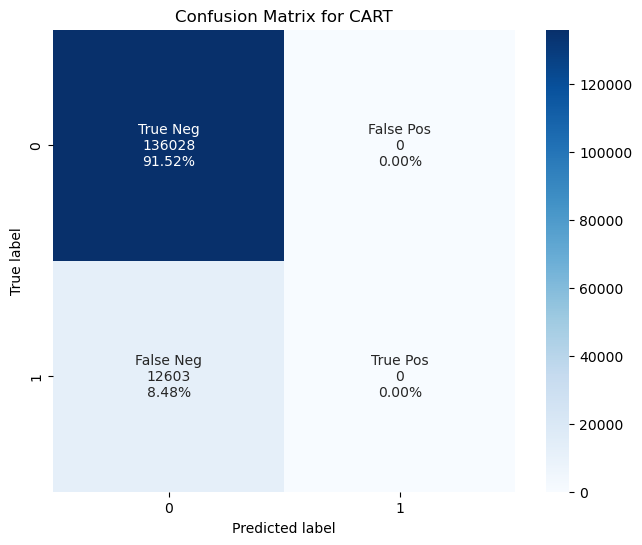

Classification Report for CART:

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    136028
           1       0.00      0.00      0.00     12603

    accuracy                           0.92    148631
   macro avg       0.46      0.50      0.48    148631
weighted avg       0.84      0.92      0.87    148631



/Users/allen/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/allen/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/allen/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


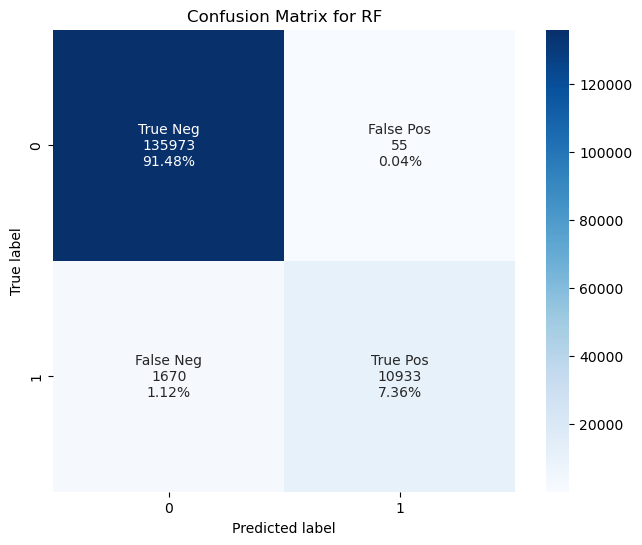

Classification Report for RF:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    136028
           1       0.99      0.87      0.93     12603

    accuracy                           0.99    148631
   macro avg       0.99      0.93      0.96    148631
weighted avg       0.99      0.99      0.99    148631



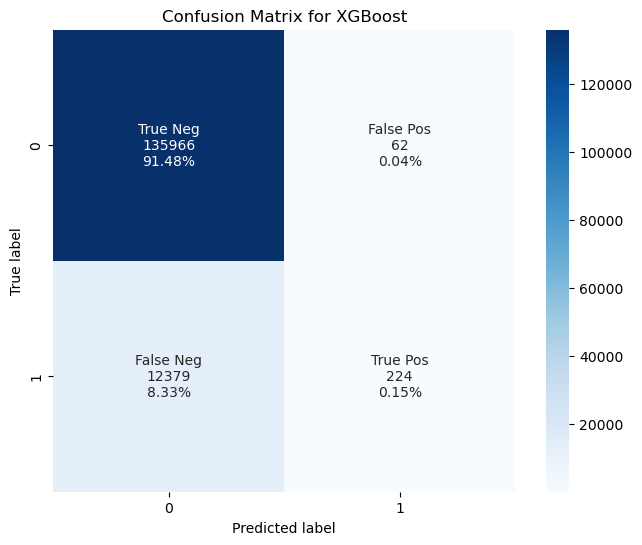

Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    136028
           1       0.78      0.02      0.03     12603

    accuracy                           0.92    148631
   macro avg       0.85      0.51      0.50    148631
weighted avg       0.91      0.92      0.88    148631



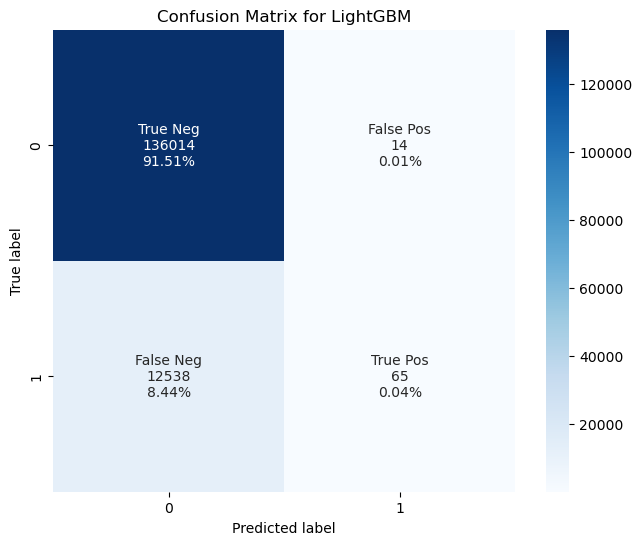

Classification Report for LightGBM:

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    136028
           1       0.82      0.01      0.01     12603

    accuracy                           0.92    148631
   macro avg       0.87      0.50      0.48    148631
weighted avg       0.91      0.92      0.88    148631



In [69]:
model_evaluation(classifiers,X_test,y_test,X_train,y_train)

# Model success evaluation with K-Fold Cross Validation



In [70]:
#models(classifiers,X,y)

In [71]:
y_test.value_counts()

TARGET
0    136028
1     12603
Name: count, dtype: int64

In [72]:
#Trying Under Sampling  to have balanced data

In [73]:
'''
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
undersample = RandomUnderSampler(random_state=0)
X_undersample, y_undersample = undersample.fit_resample(X, y)

counter = Counter(y_undersample)


# Splitting the model into train/test split
X_train, X_test, y_train, y_test,classifiers = train_test(X_undersample,y_undersample)


# Model success evaluation with Hold-Out via the complexity matrix
model_evaluation(classifiers,X_test,y_test,X_train,y_train)
'''


'\nfrom imblearn.under_sampling import RandomUnderSampler\nfrom collections import Counter\nundersample = RandomUnderSampler(random_state=0)\nX_undersample, y_undersample = undersample.fit_resample(X, y)\n\ncounter = Counter(y_undersample)\n\n\n# Splitting the model into train/test split\nX_train, X_test, y_train, y_test,classifiers = train_test(X_undersample,y_undersample)\n\n\n# Model success evaluation with Hold-Out via the complexity matrix\nmodel_evaluation(classifiers,X_test,y_test,X_train,y_train)\n'

In [74]:
'''
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
oversample = RandomOverSampler(random_state=0)
X_oversample, y_oversample = oversample.fit_resample(X, y)

counter = Counter(y_oversample)


# Splitting the model into train/test split
X_train, X_test, y_train, y_test,classifiers = train_test(X_oversample,y_oversample)


# Model success evaluation with Hold-Out via the complexity matrix
model_evaluation(classifiers,X_test,y_test,X_train,y_train)
'''

'\nfrom imblearn.over_sampling import RandomOverSampler\nfrom collections import Counter\noversample = RandomOverSampler(random_state=0)\nX_oversample, y_oversample = oversample.fit_resample(X, y)\n\ncounter = Counter(y_oversample)\n\n\n# Splitting the model into train/test split\nX_train, X_test, y_train, y_test,classifiers = train_test(X_oversample,y_oversample)\n\n\n# Model success evaluation with Hold-Out via the complexity matrix\nmodel_evaluation(classifiers,X_test,y_test,X_train,y_train)\n'

In [75]:
undersample = RandomUnderSampler(random_state=0)
X_undersample, y_undersample = undersample.fit_resample(X, y)

counter = Counter(y_undersample)


# Splitting the model into train/test split
X_train, X_test, y_train, y_test,classifiers = train_test(X_undersample,y_undersample)

Base Models....
[('CART', DecisionTreeClassifier(max_depth=4, random_state=0)), ('RF', RandomForestClassifier(random_state=0)), ('XGBoost', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)), ('LightGBM', LGBMClassifier(random_state=0, verbose=-1))]


Random Forest Classifier
Cross Validation Scores:
Accuracy :  84.93%
F1 :  85.45%
Precision :  82.81%
Recall :  88.25%
Test Accuracy :  88.61%


Text(0.5, 36.72222222222221, 'Predicted label')

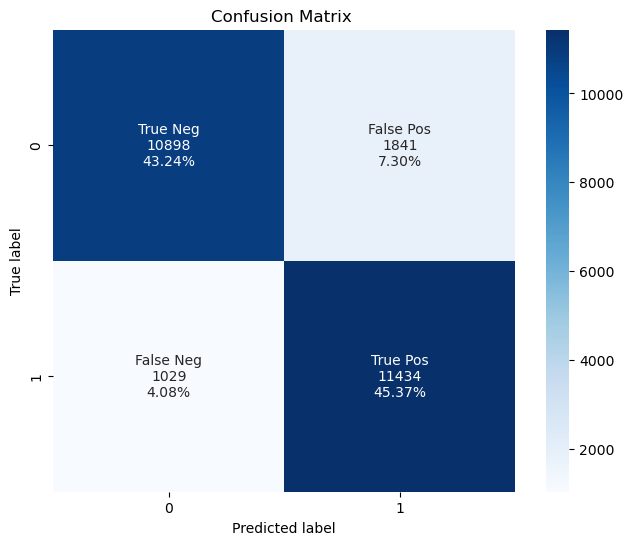

In [76]:
# Selecting Random Forest as model
model = RandomForestClassifier(random_state=0, max_features='sqrt')
model.fit(X_train, y_train)
prediction = model.predict(X_test)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
# Calculating Cross-Validation scores for different metrics
accuracy_cv = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy',n_jobs=-1).mean()
f1_cv = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1',n_jobs=-1).mean()
precision_cv = cross_val_score(model, X_train, y_train, cv=cv, scoring='precision',n_jobs=-1).mean()
recall_cv = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall',n_jobs=-1).mean()

# Printing Cross-Validation scores
print("Random Forest Classifier")
print("Cross Validation Scores:")
print("Accuracy : ", '{0:.2%}'.format(accuracy_cv))
print("F1 : ", '{0:.2%}'.format(f1_cv))
print("Precision : ", '{0:.2%}'.format(precision_cv))
print("Recall : ", '{0:.2%}'.format(recall_cv))

# Accuracy on test data
test_accuracy = accuracy_score(y_test, prediction)
print("Test Accuracy : ", '{0:.2%}'.format(test_accuracy))
y_predict = model.predict(X_test)
cm = confusion_matrix(y_test, y_predict)
names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
counts = [value for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
labels = np.asarray(labels).reshape(2, 2)

#Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, cmap='Blues', fmt='', square=True)
plt.title(f'Confusion Matrix ')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [77]:
'''
# Saving the model
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
'''

"\n# Saving the model\nimport pickle\nwith open('model.pkl', 'wb') as file:\n    pickle.dump(model, file)\nwith open('scaler.pkl', 'wb') as f:\n    pickle.dump(scaler, f)\n"

In [78]:
#Saving Model
import pickle 
with open('model.pkl','wb') as file:
    pickle.dump(model,file)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('ohe.pkl', 'wb') as f:
    pickle.dump(ohe, f)

In [79]:
X[0]

array([ 1.        ,  1.        ,  1.        ,  2.        ,  0.        ,
        0.        ,  2.        ,  0.38763894, -0.37502388, -0.16123803,
       -2.02345733, -0.46447194,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ])

In [80]:

new_pred = model.predict([X[0]])

In [81]:
new_pred

array([1])